# Modeling

Models used:

Dummy Reg, Linear Reg, SelectKBest for LinReg, Gradient Boost Reg, RandomSearchCV, Random Forest Regressor

Metrics used:
* R2, Adj R2, MSE, RMSE, MAE, MAPE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

In [2]:
print(sklearn_version)

1.1.1


### Scaling & train/test split

Scaling included here to make inverse scaling possible.

In [3]:
df_import = pd.read_csv('../data/demographic_scores_onehot.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')

In [4]:
#Train/test split & scaling

# Create training & testing sets
X = df_import.drop(['Mean Score Math', 'Mean Score EBRW'], axis=1)
y = df_import[['Mean Score Math', 'Mean Score EBRW']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=137)

scaler_X = StandardScaler()

#Fit & transform training X data
scaler_X.fit(X_train[['Median Family Income']].values)
X_train[['Median Family Income']] = scaler_X.transform(X_train[['Median Family Income']].values)

#Transform training X data
X_test[['Median Family Income']] = scaler_X.transform(X_test[['Median Family Income']].values)

In [5]:
# Combine X & y for the training sets and for testing sets
training_data = y_train.join(X_train)

# And the testing data
test_data = y_test.join(X_test)

In [6]:
#Export to csv
training_data.to_csv('../data/demog_training_data.csv')
test_data.to_csv('../data/demog_testing_data.csv')

In [7]:
psat_sat = pd.read_csv('../data/SAT_PSAT_aggregated.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')

# Fix dtypes after data import
psat_sat = psat_sat.astype({'District Number': 'str',
                 'District Name': 'str',
                 'School Number': 'str',
                 'School Name': 'str',
                 '2018 EBRW Mean SAT': 'float64',
                 '2018 Math Mean SAT': 'float64',
                 '2018 Overall Mean Score SAT': 'float64',
                 '2017 EBRW Mean PSAT10': 'float64',
                 '2017 Math Mean PSAT10': 'float64',
                 '2017 Overall Mean Score PSAT10': 'float64',
                 'Zip Code': 'str',
                 'Median Family Income': 'float64',
                 'Population': 'float64'})

psat_sat['Zip Code'] = psat_sat['Zip Code'].str.strip('.0')

In [8]:
#Train/test split

# Create training & testing sets
X = psat_sat.loc[:,['2017 EBRW Mean PSAT10','2017 Math Mean PSAT10', '2017 Overall Mean Score PSAT10']]
y = psat_sat.loc[:,['2018 EBRW Mean SAT','2018 Math Mean SAT', '2018 Overall Mean Score SAT']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=137)

In [9]:
# Combine X & y for the training sets and for testing sets
training_data = y_train.join(X_train)

# And the testing data
test_data = y_test.join(X_test)

In [10]:
#Export to csv
training_data.to_csv('../data/psat_training_data.csv')
test_data.to_csv('../data/psat_testing_data.csv')

Note: Exporting & importing data to csv's to meet project requirements

### Modeling

In [11]:
#Import training & testing data
demog_train_raw = pd.read_csv('../data/demog_training_data.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')
demog_test_raw = pd.read_csv('../data/demog_testing_data.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')

psat_train_raw = pd.read_csv('../data/psat_training_data.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')
psat_test_raw = pd.read_csv('../data/psat_testing_data.csv').drop(['Unnamed: 0'], axis=1, errors='ignore')

In [12]:
demog_train_raw.columns

Index(['Mean Score Math', 'Mean Score EBRW', 'Median Family Income',
       'Gend_Female', 'Gend_Male', 'Ethn_Asian', 'Ethn_Black', 'Ethn_Hispanic',
       'Ethn_Two or More Races', 'Ethn_White', 'FRL_FRL Eligible',
       'FRL_Not FRL Eligible', 'ELL_English Learners',
       'ELL_Not English Learners', 'IEP_Students with IEPs',
       'IEP_Students without IEPs'],
      dtype='object')

In [13]:
psat_train_raw.columns

Index(['2018 EBRW Mean SAT', '2018 Math Mean SAT',
       '2018 Overall Mean Score SAT', '2017 EBRW Mean PSAT10',
       '2017 Math Mean PSAT10', '2017 Overall Mean Score PSAT10'],
      dtype='object')

#### Only look at math scores for now.  Extremely high correlation between Math and EBRW scores so results should apply to both.

In [14]:
# Drop non-math score columns
demog_train = demog_train_raw.drop(['Mean Score EBRW'], axis=1)
demog_test = demog_test_raw.drop(['Mean Score EBRW'], axis=1)
psat_train = psat_train_raw.drop(['2018 EBRW Mean SAT', '2018 Overall Mean Score SAT', '2017 EBRW Mean PSAT10', '2017 Overall Mean Score PSAT10'], axis=1)
psat_test = psat_test_raw.drop(['2018 EBRW Mean SAT', '2018 Overall Mean Score SAT', '2017 EBRW Mean PSAT10', '2017 Overall Mean Score PSAT10'], axis=1)

In [15]:
# Drop non-EBRW score columns

demog_train_E = demog_train_raw.drop(['Mean Score Math'], axis=1)
demog_test_E = demog_test_raw.drop(['Mean Score Math'], axis=1)
psat_train_E = psat_train_raw.drop(['2018 Math Mean SAT', '2018 Overall Mean Score SAT', '2017 Math Mean PSAT10', '2017 Overall Mean Score PSAT10'], axis=1)
psat_test_E = psat_test_raw.drop(['2018 Math Mean SAT', '2018 Overall Mean Score SAT', '2017 Math Mean PSAT10', '2017 Overall Mean Score PSAT10'], axis=1)

In [16]:
# Demographic score data
y_col = 'Mean Score Math'

demog_X_train = demog_train.drop(y_col, axis=1)
demog_X_test = demog_test.drop(y_col, axis=1)
demog_y_train = demog_train.loc[:,y_col]
demog_y_test = demog_test.loc[:,y_col]


# PSAT score data
y_col = '2018 Math Mean SAT'
psat_X_train = psat_train.drop(y_col, axis=1)
psat_X_test = psat_test.drop(y_col, axis=1)
psat_y_train = psat_train.loc[:,y_col]
psat_y_test = psat_test.loc[:,y_col]

In [17]:
# Demographic score data EBRW
y_col = 'Mean Score EBRW'

demog_X_train_E = demog_train_E.drop(y_col, axis=1)
demog_X_test_E = demog_test_E.drop(y_col, axis=1)
demog_y_train_E = demog_train_E.loc[:,y_col]
demog_y_test_E = demog_test_E.loc[:,y_col]


# PSAT score data
y_col = '2018 EBRW Mean SAT'
psat_X_train_E = psat_train_E.drop(y_col, axis=1)
psat_X_test_E = psat_test_E.drop(y_col, axis=1)
psat_y_train_E = psat_train_E.loc[:,y_col]
psat_y_test_E = psat_test_E.loc[:,y_col]

#### Utility functions

In [18]:
def adj_r2(model, X, y):
    r2 = model.score(X,y)
    n = X.shape[0]
    p = X.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

def print_metrics(model, X, y):
    r_square = model.score(X, y)
    print("R2: {:.4f}".format(r_square))
    r2_adj = adj_r2(model, X, y)
    print("Adj R2: {:.4f}".format(r2_adj))
    return

def print_better_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print("MSE: {:.4f}".format(mse))
    rmse = np.sqrt(mse)
    print("RMSE: {:.4f}".format(rmse))
    mae = mean_absolute_error(y_true, y_pred)
    print("MAE: {:.4f}".format(mae))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print("MAPE: {:.4f}".format(mape))
    return

model_metrics = pd.DataFrame(index=['linreg_dem'], columns = ['mse', 'rmse', 'mae', 'mape'])
model_metrics_E = pd.DataFrame(index=['linreg_dem'], columns = ['mse', 'rmse', 'mae', 'mape'])

def update_metrics(model, y_true, y_pred):
    global model_metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    model_metrics.loc[model] = [mse, rmse, mae, mape]
    
def plot_feature_importance(model, X_train, X_test, y_test):
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize=(8, 8))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
    plt.title('Feature Importance')
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    fig.tight_layout()
    plt.show()
    return

def set_demog_XY():
    global X_train, X_test, y_train, y_test
    X_train = demog_X_train
    X_test = demog_X_test
    y_train = demog_y_train
    y_test = demog_y_test
    
def set_psat_XY():
    global X_train, X_test, y_train, y_test
    X_train = psat_X_train
    X_test = psat_X_test
    y_train = psat_y_train
    y_test = psat_y_test
    
def set_demog_E_XY():
    global X_train, X_test, y_train, y_test
    X_train = demog_X_train_E
    X_test = demog_X_test_E
    y_train = demog_y_train_E
    y_test = demog_y_test_E
    
def set_psat_E_XY():
    global X_train, X_test, y_train, y_test
    X_train = psat_X_train_E
    X_test = psat_X_test_E
    y_train = psat_y_train_E
    y_test = psat_y_test_E

## Demographic data

#### Dummy Regressor

In [19]:
set_demog_XY()

dumreg_demog = DummyRegressor(strategy='mean')
dumreg_demog.fit(X_train, y_train)
dumreg_demog.constant_

array([[507.0887937]])

#### Linear regression

In [20]:
linreg_dem = LinearRegression()
linreg_dem.fit(X_train, y_train)
y_tr_pred = linreg_dem.predict(X_train)
y_te_pred = linreg_dem.predict(X_test)

print('Train')
print_metrics(linreg_dem, X_train, y_train)
print('\nTest')
print_metrics(linreg_dem, X_test, y_test)
print('\n')

update_metrics('linreg_dem', y_test, y_te_pred)
print_better_metrics(y_test, y_te_pred)

Train
R2: 0.6867
Adj R2: 0.6786

Test
R2: 0.6757
Adj R2: 0.6394


MSE: 1070.2203
RMSE: 32.7142
MAE: 24.8174
MAPE: 0.0487


In [21]:
model_metrics

,mse,rmse,mae,mape
linreg_dem,1070.220316,32.714222,24.817356,0.048672


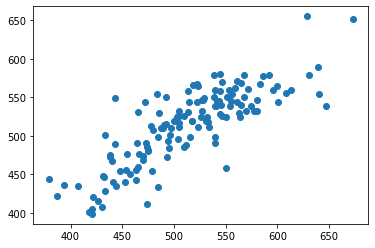

In [22]:
plt.scatter(y_test, y_te_pred)

### Select K Best

In [23]:
set_demog_XY()

skb = SelectKBest(f_regression, k=13)
skb.fit(X_train, y_train)

X_tr_skb = skb.transform(X_train)
X_te_skb = skb.transform(X_test)

linreg_kb_dem = LinearRegression()
linreg_kb_dem.fit(X_tr_skb, y_train)

print('Train')
print_metrics(linreg_kb_dem, X_tr_skb, y_train)
print('\nTest')
print_metrics(linreg_kb_dem, X_te_skb, y_test)


Train
R2: 0.6867
Adj R2: 0.6792

Test
R2: 0.6757
Adj R2: 0.6422


In [24]:
pipe = make_pipeline(SelectKBest(f_regression),
                    LinearRegression())

In [25]:
set_demog_XY()

pipe.fit(X_train, y_train)

y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

y_te_pred = pipe.predict(X_test)

update_metrics('SelectKBest (pipe)', y_test, y_te_pred)


print("R2 Train: {:.4f}".format(r2_score(y_train, y_tr_pred)))
print("R2 Test: {:.4f}".format(r2_score(y_test, y_te_pred)))

R2 Train: 0.6586
R2 Test: 0.6396


Worse than linear regression without SKB.

In [26]:
# Gridsearch for k in SKB

set_demog_XY()

k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

lr_grid_cv.fit(X_train, y_train)


score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [27]:
lr_grid_cv.best_params_

{'selectkbest__k': 13}

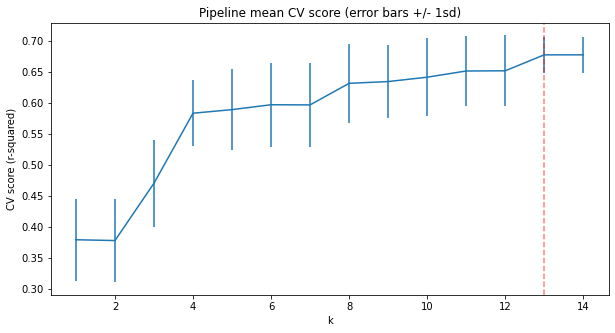

In [28]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

Trivial difference in CV score between k=13 and k=14.

In [29]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Ethn_Asian                   129.634240
IEP_Students without IEPs     72.173894
Ethn_Two or More Races        57.268513
Ethn_White                    52.410218
Median Family Income          21.635503
Ethn_Hispanic                 18.451887
FRL_Not FRL Eligible          17.748549
ELL_Not English Learners      17.340576
Gend_Male                      6.935456
Gend_Female                   -6.935456
ELL_English Learners         -17.340576
FRL_FRL Eligible             -17.748549
IEP_Students with IEPs       -72.173894
dtype: float64

Something doesn't check out here.

### Gradient Boosting Regressor

Train
R2: 0.8038
Adj R2: 0.7988

Test
R2: 0.6928
Adj R2: 0.6584


MSE: 1013.6018
RMSE: 31.8371
MAE: 23.6339
MAPE: 0.0461


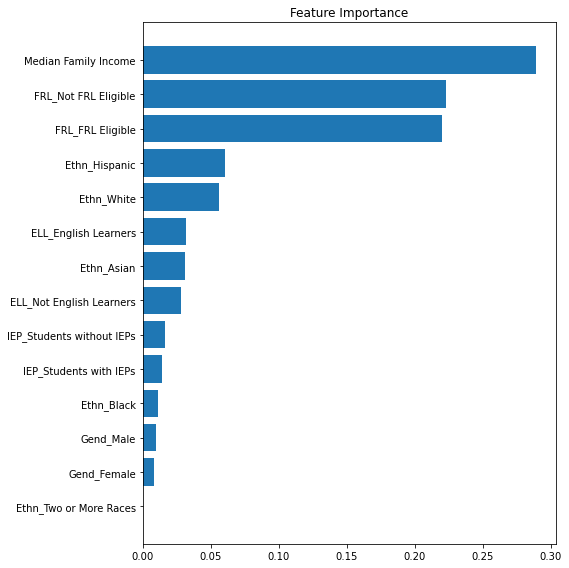

In [30]:
set_demog_XY()

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

gbreg_dem = GradientBoostingRegressor(**params)
gbreg_dem.fit(X_train, y_train)

y_te_pred = gbreg_dem.predict(X_test)

print('Train')
print_metrics(gbreg_dem, X_train, y_train)
print('\nTest')
print_metrics(gbreg_dem, X_test, y_test)

update_metrics('gbreg_dem', y_test, y_te_pred)
print('\n')
print_better_metrics(y_test, y_te_pred)

plot_feature_importance(gbreg_dem, X_train, X_test, y_test)

#### Gradient Boost Reg - RandomSearchCV

In [31]:
set_demog_XY()

param_distributions = {
    "n_estimators": range(100,700),
    "max_depth": range(2,10),
    "min_samples_split": range(2,10),
    "learning_rate": [0.001, 0.01, 0.1, 1]
    }

rscv = RandomizedSearchCV(gbreg_dem, param_distributions, random_state=136,
                              n_iter = 20
                              )
search_gbreg_cv_dem = rscv.fit(X_train, y_train)

Train
R2: 0.8377
Adj R2: 0.8335

Test
R2: 0.7401
Adj R2: 0.7110


MSE: 857.6946
RMSE: 29.2864
MAE: 21.6226
MAPE: 0.0421


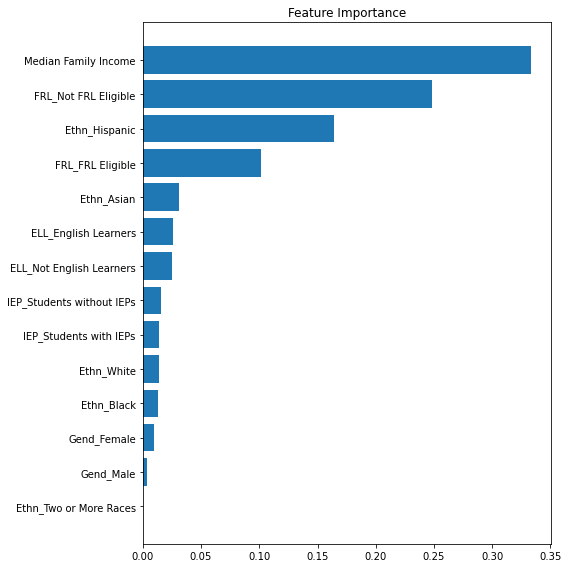

In [32]:
set_demog_XY()

gbreg_cv_dem = GradientBoostingRegressor(**search_gbreg_cv_dem.best_params_,  loss= "squared_error")
gbreg_cv_dem.fit(X_train, y_train)

y_te_pred = gbreg_cv_dem.predict(X_test)

print('Train')
print_metrics(gbreg_cv_dem, X_train, y_train)
print('\nTest')
print_metrics(gbreg_cv_dem, X_test, y_test)

update_metrics('gbreg_cv_dem', y_test, y_te_pred)
print('\n')
print_better_metrics(y_test, y_te_pred)

plot_feature_importance(gbreg_cv_dem, X_train, X_test, y_test)

#### Random Forest

In [33]:
set_demog_XY()

rfr_dem = RandomForestRegressor()
rfr_dem.fit(X_train, y_train)

#mse = mean_squared_error(y_test, y_pred)
#print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

y_tr_pred = rfr_dem.predict(X_train)
y_te_pred = rfr_dem.predict(X_test)


print("R2 Train: {:.4f}".format(r2_score(y_train, y_tr_pred)))
print("R2 Test: {:.4f}".format(r2_score(y_test, y_te_pred)))


R2 Train: 0.9233
R2 Test: 0.6172


In [34]:
# Random Forest Regression with Random Search CV

set_demog_XY()

param_distributions = {
    "n_estimators": range(50,1000),
    "max_depth": range(2,30)#,
    }

rscv_rfr_dem = RandomizedSearchCV(rfr_dem, param_distributions, random_state=137,
                              n_iter = 10
                              )
search_rfr_dem = rscv_rfr_dem.fit(X_train, y_train)

rfr_dem = GradientBoostingRegressor(**search_rfr_dem.best_params_,  loss= "squared_error")
rfr_dem.fit(X_train, y_train)

print(search_rfr_dem.best_params_)

y_te_pred = rfr_dem.predict(X_test)

print('Train')
print_metrics(rfr_dem, X_train, y_train)
print('\nTest')
print_metrics(rfr_dem, X_test, y_test)

update_metrics('rfr_dem', y_test, y_te_pred)
print('\n')
print_better_metrics(y_test, y_te_pred)

{'n_estimators': 680, 'max_depth': 6}
Train
R2: 0.9581
Adj R2: 0.9570

Test
R2: 0.6531
Adj R2: 0.6142


MSE: 1144.8273
RMSE: 33.8353
MAE: 26.1432
MAPE: 0.0517


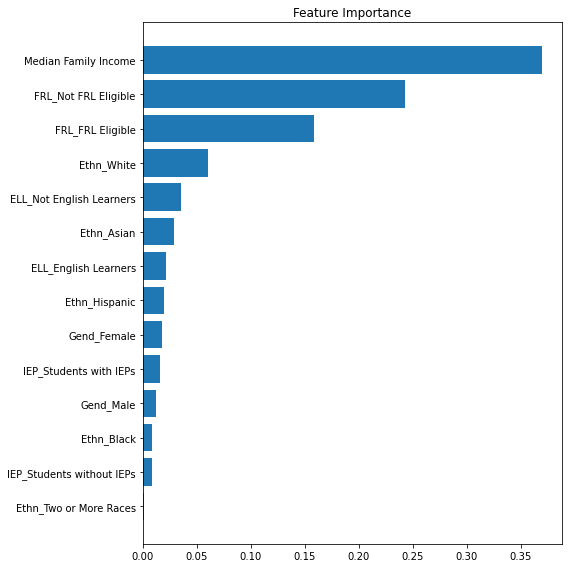

In [35]:
plot_feature_importance(rfr_dem, X_train, X_test, y_test)

In [36]:
model_metrics

,mse,rmse,mae,mape
linreg_dem,1070.220316,32.714222,24.817356,0.048672
SelectKBest (pipe),1189.455594,34.488485,25.633965,0.050429
gbreg_dem,1013.601752,31.837113,23.633867,0.046103
gbreg_cv_dem,857.694585,29.286423,21.622648,0.042141
rfr_dem,1144.827274,33.835296,26.143229,0.051704


## Best model:  Gradient Boost Regression with Random Search CV

### Now do it again with PSAT/SAT scores

In [37]:
set_psat_XY()

dumreg_demog = DummyRegressor(strategy='mean')
dumreg_demog.fit(X_train, y_train)
dumreg_demog.constant_

array([[488.64179104]])

In [38]:
#Linear Regression

set_psat_XY()

linreg_psat = LinearRegression()
linreg_psat.fit(X_train, y_train)
y_tr_pred = linreg_psat.predict(X_train)
y_te_pred = linreg_psat.predict(X_test)

print('Train')
print_metrics(linreg_psat, X_train, y_train)
print('\nTest')
print_metrics(linreg_psat, X_test, y_test)

print('\n')

update_metrics('linreg_psat', y_test, y_te_pred)

print_better_metrics(y_test, y_te_pred)

Train
R2: 0.9490
Adj R2: 0.9488

Test
R2: 0.9493
Adj R2: 0.9486


MSE: 134.6117
RMSE: 11.6022
MAE: 9.3892
MAPE: 0.0201


In [39]:
#Gradient Boost Regression

set_psat_XY()

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

gbreg_psat = GradientBoostingRegressor(**params)
gbreg_psat.fit(X_train, y_train)

#mse = mean_squared_error(y_test, y_pred)
#print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

y_te_pred = gbreg_psat.predict(X_test)

update_metrics('gbreg_psat', y_test, y_te_pred)

print('Train')
print_metrics(gbreg_psat, X_train, y_train)
print('\nTest')
print_metrics(gbreg_psat, X_test, y_test)

print('\n')
print_better_metrics(y_test, y_te_pred)

Train
R2: 0.9695
Adj R2: 0.9694

Test
R2: 0.9424
Adj R2: 0.9415


MSE: 153.0193
RMSE: 12.3701
MAE: 9.4665
MAPE: 0.0200


In [40]:
#Random Search CV for gradient boost

set_psat_XY()

param_distributions = {
    "n_estimators": range(100,700),
    "max_depth": range(2,10),
    "min_samples_split": range(2,10),
    "learning_rate": [0.001, 0.01, 0.1, 1]
    }

rscv = RandomizedSearchCV(gbreg_dem, param_distributions, random_state=136,
                              n_iter = 10
                              )
search_gbreg_psat_cv = rscv.fit(X_train, y_train)

gbreg_psat_cv = GradientBoostingRegressor(**search_gbreg_psat_cv.best_params_,  loss= "squared_error")
gbreg_psat_cv.fit(X_train, y_train)

y_te_pred = gbreg_psat_cv.predict(X_test)

update_metrics('gbreg_cv_psat', y_test, y_te_pred)

print('Train')
print_metrics(gbreg_psat_cv, X_train, y_train)
print('\nTest')
print_metrics(gbreg_psat_cv, X_test, y_test)

print_better_metrics(y_test, y_te_pred)

Train
R2: 0.9734
Adj R2: 0.9733

Test
R2: 0.9341
Adj R2: 0.9331
MSE: 175.1495
RMSE: 13.2344
MAE: 10.0353
MAPE: 0.0211


In [41]:
model_metrics

,mse,rmse,mae,mape
linreg_dem,1070.220316,32.714222,24.817356,0.048672
SelectKBest (pipe),1189.455594,34.488485,25.633965,0.050429
gbreg_dem,1013.601752,31.837113,23.633867,0.046103
gbreg_cv_dem,857.694585,29.286423,21.622648,0.042141
rfr_dem,1144.827274,33.835296,26.143229,0.051704
linreg_psat,134.611716,11.602229,9.389181,0.020059
gbreg_psat,153.019273,12.370096,9.466491,0.019991
gbreg_cv_psat,175.149453,13.234404,10.035267,0.021111


Best model for demographic data: gradient boost regression with cross validation.  MAPE ~ 4.2%

Best model for PSAT data: linear regresion.  MAPE ~ 2.0%

### Model EBRW scores

#### Demographic data first

In [42]:
set_demog_E_XY()

# Gradient boost regression

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

gbreg_dem_E = GradientBoostingRegressor(**params)
gbreg_dem_E.fit(X_train, y_train);

In [43]:
# Random search CV
param_distributions = {
    "n_estimators": range(100,700),
    "max_depth": range(2,10),
    "min_samples_split": range(2,10),
    "learning_rate": [0.001, 0.01, 0.1, 1]
    }

rscv = RandomizedSearchCV(gbreg_dem_E, param_distributions, random_state=136, n_iter = 20)
search_gbreg_cv_dem_E = rscv.fit(X_train, y_train)

gbreg_cv_dem_E = GradientBoostingRegressor(**search_gbreg_cv_dem_E.best_params_,  loss= "squared_error")
gbreg_cv_dem_E.fit(X_train, y_train)

y_te_pred = gbreg_cv_dem_E.predict(X_test)

MSE: 625.9626
RMSE: 25.0192
MAE: 19.6916
MAPE: 0.0373


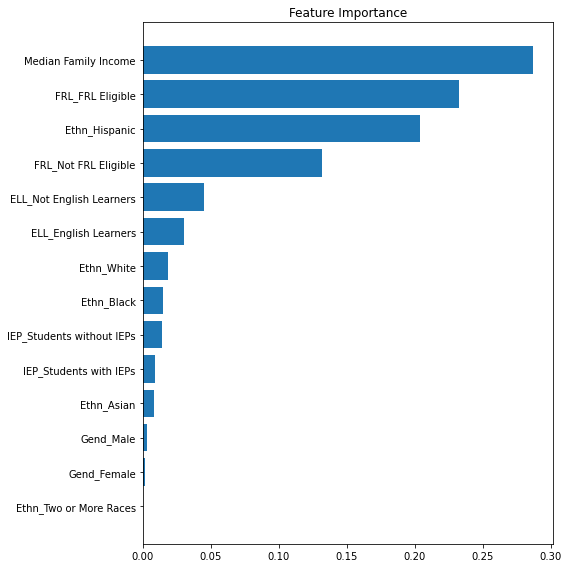

In [44]:
# Metrics

mse = mean_squared_error(y_test, y_te_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_te_pred)
mape = mean_absolute_percentage_error(y_test, y_te_pred)
model_metrics_E.loc['gbreg_cv_dem_E'] = [mse, rmse, mae, mape]

update_metrics('gbreg_cv_dem_E',y_test,y_te_pred)

print_better_metrics(y_test, y_te_pred)

plot_feature_importance(gbreg_cv_dem_E, X_train, X_test, y_test)

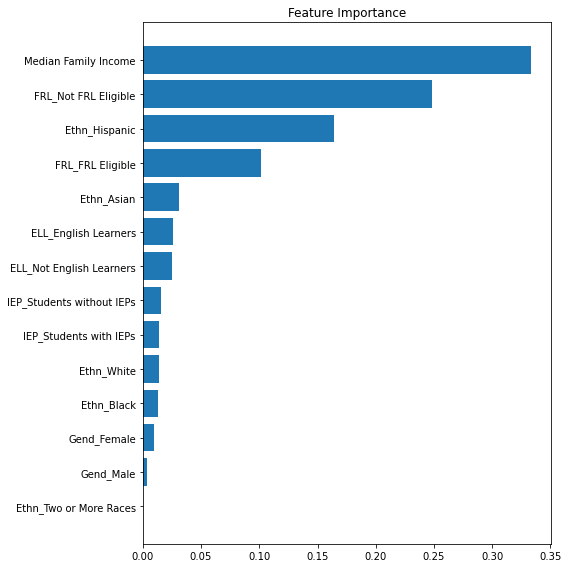

In [45]:
# Compare important features to math score predictions

set_demog_XY()
plot_feature_importance(gbreg_cv_dem, X_train, X_test, y_test)

Hispanic ethnicity has greater importance for EBRW scores than for Math scores.

#### Now PSAT data

In [46]:
#Linear Regression
set_psat_E_XY()

linreg_psat_E = LinearRegression()
linreg_psat_E.fit(X_train, y_train)
y_tr_pred = linreg_psat_E.predict(X_train)
y_te_pred = linreg_psat_E.predict(X_test)


update_metrics('linreg_psat_E', y_test, y_te_pred)

print_better_metrics(y_test, y_te_pred)

MSE: 113.4879
RMSE: 10.6531
MAE: 7.9071
MAPE: 0.0157


In [47]:
model_metrics

,mse,rmse,mae,mape
linreg_dem,1070.220316,32.714222,24.817356,0.048672
SelectKBest (pipe),1189.455594,34.488485,25.633965,0.050429
gbreg_dem,1013.601752,31.837113,23.633867,0.046103
gbreg_cv_dem,857.694585,29.286423,21.622648,0.042141
rfr_dem,1144.827274,33.835296,26.143229,0.051704
linreg_psat,134.611716,11.602229,9.389181,0.020059
gbreg_psat,153.019273,12.370096,9.466491,0.019991
gbreg_cv_psat,175.149453,13.234404,10.035267,0.021111
gbreg_cv_dem_E,625.962575,25.019244,19.691558,0.03734
linreg_psat_E,113.487902,10.65307,7.907126,0.01569


MAPE for demographic data EBRW score: ~3.7%

MAPE for PSAT data EBRW score: ~1.6%

EBRW predictions slightly more accurate.

Demographic data produces predictions with twice the error as PSAT data.

**Bonus conclusion:**  Using SAT scores to evaluate a school's academic performance is meaningless if SAT scores can be predicted before considering anything academic.

However using demographics-based predictions can be used to determine if a school is performing better or worse than expected.